In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import argparse
import logging
import math
import os
import random
from collections import namedtuple
from typing import Optional, Union
from gpytorch.kernels import RBFKernel, MaternKernel

os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import matplotlib.pyplot as plt
import numpy as np
import torch
import tqdm
from torch import distributions, nn, optim

import torchsde
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# w/ underscore -> numpy; w/o underscore -> torch.
Data = namedtuple('Data', ['ts_', 'ts_ext_', 'ts_vis_', 'ts', 'ts_ext', 'ts_vis', 'ys', 'ys_'])
import sys 
sys.path.append("../..")
lengthscale = 1
def make_segmented_cosine_data():
    ts_ = np.concatenate((np.linspace(0.3, 0.8, 10), np.linspace(1.2, 1.5, 10)), axis=0)
    ts_ext_ = np.array([0.] + list(ts_) + [2.0])
    ts_vis_ = np.linspace(0., 2.0, 300)
    ys_ = np.cos(ts_ * (2. * math.pi))[:, None]

    ts = torch.tensor(ts_).float()
    ts_ext = torch.tensor(ts_ext_).float()
    ts_vis = torch.tensor(ts_vis_).float()
    ys = torch.tensor(ys_).float().to(device)
    return Data(ts_, ts_ext_, ts_vis_, ts, ts_ext, ts_vis, ys, ys_)


def make_irregular_sine_data():
    ts_ = np.sort(np.random.uniform(low=0.4, high=1.6, size=16))
    ts_ext_ = np.array([0.] + list(ts_) + [2.0])
    ts_vis_ = np.linspace(0., 2.0, 300)
    ys_ = np.sin(ts_ * (2. * math.pi))[:, None] * 0.8

    ts = torch.tensor(ts_).float()
    ts_ext = torch.tensor(ts_ext_).float()
    ts_vis = torch.tensor(ts_vis_).float()
    ys = torch.tensor(ys_).float().to(device)
    return Data(ts_, ts_ext_, ts_vis_, ts, ts_ext, ts_vis, ys, ys_)

def make_irregular_gp_data():
    k = MaternKernel(nu=0.5)
    k.lengthscale = lengthscale
    ts = np.concatenate(
        [
            np.random.uniform(low=0.1, high=0.5, size=5),
            np.random.uniform(low=1.5, high=1.9, size=5)
        ],
        axis=0
    )
    ts_ = np.sort(ts)
    ts_ext_ = np.array([0.] + list(ts_) + [2.0])
    ts_vis_ = np.linspace(0., 2.0, 300)
    K = k(torch.Tensor(ts_)).evaluate().double() + (1e-6*torch.eye(ts_.shape[0])).double()
    L = torch.linalg.cholesky(K)
    ys_ = L.detach().cpu().numpy() @ np.random.normal(size=(K.shape[0], 1)).astype(np.float64)

    ts = torch.tensor(ts_).float()
    ts_ext = torch.tensor(ts_ext_).float()
    ts_vis = torch.tensor(ts_vis_).float()
    ys = torch.tensor(ys_).float().to(device)
    return Data(ts_, ts_ext_, ts_vis_, ts, ts_ext, ts_vis, ys, ys_)

def make_data(data_name="irregular_gp"):
    data_constructor = {
        'segmented_cosine': make_segmented_cosine_data,
        'irregular_sine': make_irregular_sine_data,
        'irregular_gp': make_irregular_gp_data
    }[data_name]
    return data_constructor()

/home/hbz15/vector/torchsde/.env/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def manual_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
manual_seed(0)

In [4]:
# Dataset.
ts_, ts_ext_, ts_vis_, ts, ts_ext, ts_vis, ys, ys_ = make_data()
# Plotting parameters.
vis_batch_size = 1024
ylims = (-3, 3)
alphas = [0.55]
# percentiles = [0.999, 0.99, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]
percentiles = [0.95]
color = "blue"

In [27]:
method = "euler"
dt = 1e-3
adaptive = False
rtol = 1e-3
atol = 1e-3
adjoint = False
sdeint_fn = torchsde.sdeint_adjoint if adjoint else torchsde.sdeint
kl_anneal_iters = 100
dpi = 300
batch_size=512
train_iters=5000
pause_iters=50
scale=0.01

In [28]:
vis_idx = np.random.permutation(vis_batch_size)
# From https://colorbrewer2.org/.
if color == "blue":
    sample_colors = ('#8c96c6', '#8c6bb1', '#810f7c')
    fill_color = '#9ebcda'
    mean_color = '#4d004b'
    num_samples = len(sample_colors)
else:
    sample_colors = ('#fc4e2a', '#e31a1c', '#bd0026')
    fill_color = '#fd8d3c'
    mean_color = '#800026'
    num_samples = len(sample_colors)

eps = torch.randn(vis_batch_size, 1).to(device)  # Fix seed for the random draws used in the plots.
bm = torchsde.BrownianInterval(
    t0=ts_vis[0],
    t1=ts_vis[-1],
    size=(vis_batch_size, 1),
    device=device,
    levy_area_approximation='space-time'
)  # We need space-time Levy area to use the SRK solver

In [29]:
from multiscale_sde.sde import GPSDE
class LinearScheduler(object):
    def __init__(self, iters, maxval=1.0):
        self._iters = max(1, iters)
        self._val = maxval / self._iters
        self._maxval = maxval

    def step(self):
        self._val = min(self._maxval, self._val + self._maxval / self._iters)

    @property
    def val(self):
        return self._val


class EMAMetric(object):
    def __init__(self, gamma: Optional[float] = .99):
        super(EMAMetric, self).__init__()
        self._val = 0.
        self._gamma = gamma

    def step(self, x: Union[torch.Tensor, np.ndarray]):
        x = x.detach().cpu().numpy() if torch.is_tensor(x) else x
        self._val = self._gamma * self._val + (1 - self._gamma) * x
        return self._val

    @property
    def val(self):
        return self._val

In [30]:
# Model.
model = GPSDE(sdeint_fn, device=device, lengthscale=lengthscale).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-2)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=.999)
kl_scheduler = LinearScheduler(iters=kl_anneal_iters)
logpy_metric = EMAMetric()
kl_metric = EMAMetric()
loss_metric = EMAMetric()

In [10]:
## GP ELBO
import gpytorch
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.MaternKernel(nu=0.5)

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
# get exact GP posterior
model = ExactGPModel(torch.Tensor(ts_), torch.Tensor(ys_)[:,0], likelihood)
model.likelihood.noise = 0.01**2
model.covar_module.lengthscale = lengthscale
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()


GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

In [64]:
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
output = model(torch.Tensor(ts_))
# Calc loss and backprop gradients
gp_loss = mll(output, torch.Tensor(ys_[:,0])).item()

/home/hbz15/vector/torchsde/.env/lib/python3.8/site-packages/gpytorch/models/exact_gp.py:274: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


In [65]:
gp_loss

3.340695858001709

In [31]:
def manual_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)


def _stable_division(a, b, epsilon=1e-7):
    b = torch.where(b.abs().detach() > epsilon, b, torch.full_like(b, fill_value=epsilon) * b.sign())
    return a / b
lengthscale = 1 
class LatentSDE(torchsde.SDEIto):

    def __init__(self, theta=1.0, mu=0.0, sigma=1, lengthscale=0.5, device="cpu"):
        super(LatentSDE, self).__init__(noise_type="diagonal")
        logvar = math.log(sigma ** 2 / (2. * theta))
        # logvar = 1
        std = 1

        # Prior drift.
        self.register_buffer("theta", torch.tensor([[theta]]))
        self.register_buffer("mu", torch.tensor([[mu]]))
        self.register_buffer("sigma", torch.tensor([[sigma]]))

        # p(y0).
        self.register_buffer("py0_mean", torch.tensor([[mu]]))
        # self.register_buffer("py0_logvar", torch.tensor([[logvar]]))
        self.register_buffer("py0_std", torch.tensor([[std]]))

        # Approximate posterior drift: Takes in 2 positional encodings and the state.
        self.net = nn.Sequential(
            nn.Linear(3, 200),
            nn.Tanh(),
            nn.Linear(200, 200),
            nn.Tanh(),
            nn.Linear(200, 1)
        )
        # Initialization trick from Glow.
        self.net[-1].weight.data.fill_(0.)
        self.net[-1].bias.data.fill_(0.)

        # q(y0).
        self.qy0_mean = nn.Parameter(torch.tensor([[mu]]), requires_grad=True)
        self.qy0_logvar = nn.Parameter(torch.tensor([[logvar]]), requires_grad=True)
        self.lengthscale = lengthscale
        self.device = device

    def f(self, t, y):  # Approximate posterior drift.
        if t.dim() == 0:
            t = torch.full_like(y, fill_value=t)
        # Positional encoding in transformers for time-inhomogeneous posterior.
        return self.net(torch.cat((torch.sin(t), torch.cos(t), y), dim=-1))

    def g(self, t, y):  # Shared diffusion.
        # return self.sigma.repeat(y.size(0), 1)
        # drift matrix = sigma^2 * sqrt(2 / l) for Matern12 kernel (diffusion of BM is 2/l)
        return torch.ones(y.size(0), 1, device=self.device) * math.sqrt(2 / self.lengthscale)

    def h(self, t, y):  # Prior drift.
        return -1/self.lengthscale * y

    def f_aug(self, t, y):  # Drift for augmented dynamics with logqp term.
        y = y[:, 0:1]
        f, g, h = self.f(t, y), self.g(t, y), self.h(t, y)
        u = _stable_division(f - h, g)
        f_logqp = .5 * (u ** 2).sum(dim=1, keepdim=True)
        return torch.cat([f, f_logqp], dim=1)

    def g_aug(self, t, y):  # Diffusion for augmented dynamics with logqp term.
        y = y[:, 0:1]
        g = self.g(t, y)
        g_logqp = torch.zeros_like(y)
        return torch.cat([g, g_logqp], dim=1)

    def forward(self, ts, batch_size, eps=None):
        eps = torch.randn(batch_size, 1).to(self.qy0_std) if eps is None else eps
        y0 = self.qy0_mean + eps * self.qy0_std
        qy0 = distributions.Normal(loc=self.qy0_mean, scale=self.qy0_std)
        py0 = distributions.Normal(loc=self.py0_mean, scale=self.py0_std)
        logqp0 = distributions.kl_divergence(qy0, py0).sum(dim=1)  # KL(t=0).

        aug_y0 = torch.cat([y0, torch.zeros(batch_size, 1).to(y0)], dim=1)
        aug_ys = sdeint_fn(
            sde=self,
            y0=aug_y0,
            ts=ts,
            method="euler",
            dt=1e-2,
            adaptive=False,
            rtol=1e-3,
            atol=1e-3,
            names={'drift': 'f_aug', 'diffusion': 'g_aug'}
        )
        ys, logqp_path = aug_ys[:, :, 0:1], aug_ys[-1, :, 1]
        logqp = (logqp0 + logqp_path).mean(dim=0)  # KL(t=0) + KL(path).
        return ys, logqp

    ### skipping operations
    def forward_skip(self, batch_size, ts_segments, eps=None):

        # suppose we learn the stationary distribution
        eps = torch.randn(batch_size, 1).to(self.qy0_std) if eps is None else eps
        y0 = self.qy0_mean + eps * self.qy0_std
        qy0 = distributions.Normal(loc=self.qy0_mean, scale=self.qy0_std)
        py0 = distributions.Normal(loc=self.py0_mean, scale=self.py0_std)
        logqp0 = distributions.kl_divergence(qy0, py0).sum(dim=1)  # KL(t=0).
        aug_y0 = torch.cat([y0, torch.zeros(batch_size, 1).to(y0)], dim=1)
        
        for i, ts_segment in enumerate(ts_segments):
            # ts_segment = ts[(ts >= t_starts[i]) & (ts <= t_ends[i])]     
            # ts_segment[0] -= mixing_time
            # ts_segment[-1] += mixing_time
            # ts_segment = ts_segments[i]
            aug_ys = sdeint_fn(
                sde=self,
                y0=aug_y0,
                ts=ts_segment,
                method="euler",
                dt=1e-2,
                adaptive=False,
                rtol=1e-3,
                atol=1e-3,
                names={'drift': 'f_aug', 'diffusion': 'g_aug'}
            )
            ys_segment, logqp_path = aug_ys[:, :, 0:1], aug_ys[-1, :, :1]
            if i == 0:
                ys = ys_segment[1:-1]
            else:
                ys = torch.concat([ys, ys_segment[1:-1]], axis=0)
            eps = torch.randn(batch_size, 1).to(self.qy0_std)
            y0 = self.qy0_mean + eps * self.qy0_std
            aug_y0 = torch.cat([y0, logqp_path], dim=1)
        logqp_path = aug_ys[-1, :, 1]
        logqp = (logqp0 + logqp_path).mean(dim=0)  # KL(t=0) + KL(path).
        return ys, logqp

    def sample_p(self, ts, batch_size, eps=None, bm=None):
        eps = torch.randn(batch_size, 1).to(self.py0_mean) if eps is None else eps
        y0 = self.py0_mean + eps * self.py0_std
        return sdeint_fn(self, y0, ts, bm=bm, method='srk', dt=1e-2, names={'drift': 'h'})

    def sample_q(self, ts, batch_size, eps=None, bm=None):
        eps = torch.randn(batch_size, 1).to(self.qy0_mean) if eps is None else eps
        y0 = self.qy0_mean + eps * self.qy0_std
        return sdeint_fn(self, y0, ts, bm=bm, method='srk', dt=1e-2)

    # @property
    # def py0_std(self):
    #     return torch.exp(.5 * self.py0_logvar)

    @property
    def qy0_std(self):
        return torch.exp(.5 * self.qy0_logvar)

In [32]:
model = LatentSDE(device=device, lengthscale=lengthscale).to(device)


In [33]:
sdeint_fn = torchsde.sdeint


In [42]:
import pandas as pd

In [43]:
ckpt_epochs = np.linspace(0, 4950, 100).astype(int)
df_elbo = pd.DataFrame(columns=["epoch", "latentsde", "latentsde_skip"])
df_elbo["epoch"] = ckpt_epochs
df_elbo["epoch"] = df_elbo["epoch"].astype(int)

In [44]:
model.eval()

LatentSDE(
  (net): Sequential(
    (0): Linear(in_features=3, out_features=200, bias=True)
    (1): Tanh()
    (2): Linear(in_features=200, out_features=200, bias=True)
    (3): Tanh()
    (4): Linear(in_features=200, out_features=1, bias=True)
  )
)

In [45]:
ts

tensor([0.2695, 0.3180, 0.3195, 0.3411, 0.3861, 1.6534, 1.6750, 1.7584, 1.8567,
        1.8855])

In [46]:
## setup latentsde skip parameters
# mixing time
mixing_time = 0.3
# when to begin solving
t_starts = torch.Tensor([0.0000, 0.4661])
# when to stop solving
t_ends = torch.Tensor([1.5302, 2])

## suppose we start from y0 (data driven)
ts_segments = []
ts_queres = []
for i in range(t_starts.size()[0]):
    ts_segment = ts[(ts >= t_starts[i]) & (ts <= t_ends[i])]     
    ts_segment = torch.cat([ts_segment[:1] -mixing_time, ts_segment])
    ts_segment = torch.cat([ts_segment, ts_segment[-1:] + mixing_time])
    ts_segments.append(ts_segment)

## suppose we start from y0 (start from stationary distribution - what's the stationary distribution
## of matern12?)

In [79]:
for i, epoch in enumerate(ckpt_epochs):
    likelihood_constructor = {"laplace": distributions.Laplace, "normal": distributions.Normal}["normal"]
    # calculate ELBO for latentSDE without skipping
    model.load_state_dict(torch.load(f"gp_matern12/ckpts/global_step_{epoch}.ckpt")["model"])
    zs, kl = model.forward(batch_size=batch_size, ts=ts_ext)
    zs = zs.squeeze()
    zs = zs[1:-1]
    likelihood = likelihood_constructor(loc=zs, scale=0.01)
    logpy = likelihood.log_prob(ys).sum(dim=0).mean(dim=0)
    loss = -logpy + kl * kl_scheduler.val
    df_elbo.loc[i, "latentsde"] = -loss.item()
    
    # calculate ELBO for latentSDE with skipping
    model.load_state_dict(torch.load(f"gp_matern12_skip/ckpts/global_step_{epoch}.ckpt")["model"])
    zs, kl = model.forward_skip(batch_size=batch_size, ts_segments=ts_segments)
    zs = zs.squeeze()
    likelihood = likelihood_constructor(loc=zs, scale=0.01)
    logpy = likelihood.log_prob(ys).sum(dim=0).mean(dim=0)
    loss = -logpy + kl * kl_scheduler.val
    df_elbo.loc[i, "latentsde_skip"] = -loss.item()

In [82]:
gp_loss

3.340695858001709

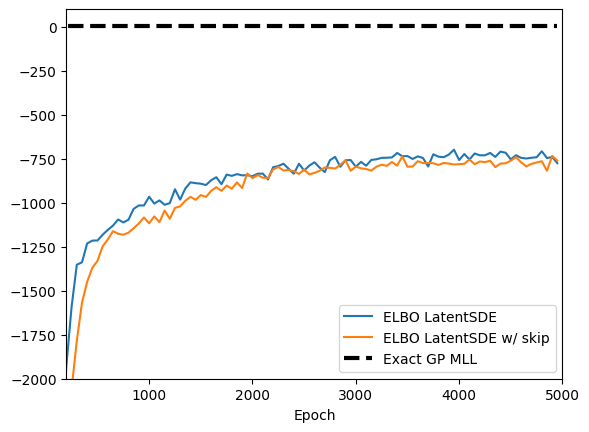

In [107]:
plt.plot(ckpt_epochs, df_elbo["latentsde"], color="C0", label="ELBO LatentSDE")
plt.plot(ckpt_epochs, df_elbo["latentsde_skip"], color="C1", label="ELBO LatentSDE w/ skip")
plt.hlines(y = gp_loss, xmin = 0, xmax = 4950, color='black', linestyle = 'dashed', linewidth = 3, 
label="Exact GP MLL")
plt.ylim(-2000, 100)
plt.xlim(200, 5000)
plt.xlabel("Epoch")
plt.legend(loc="lower right")
plt.savefig("ELBO.pdf")


In [105]:
df_elbo

,epoch,latentsde,latentsde_skip
0,0,-152644.0625,-80534.789062
1,50,-2418.140137,-2124.115234
2,100,-2329.462402,-2313.312744
3,150,-2316.840088,-2249.350586
4,200,-1918.952148,-2224.4646
...,...,...,...
95,4750,-741.530579,-771.389282
96,4800,-707.679688,-764.294006
97,4850,-746.503967,-818.717163
98,4900,-739.713928,-733.655884


In [47]:
import glob
from PIL import Image

# filepaths
fp_out = "gp_matern12_skip/evolution_posterior.gif"

# https://pillow.readthedocs.io/en/stable/handbook/image-file-formats.html#gif
imgs = (Image.open(f"gp_matern12_skip/global_step_{i}.png") for i in ckpt_epochs)
img = next(imgs)  # extract first image from iterator
img.save(fp=fp_out, format='GIF', append_images=imgs,
         save_all=True, duration=200, loop=0)

In [48]:
import glob
from PIL import Image

# filepaths
fp_out = "gp_matern12/evolution_posterior.gif"

# https://pillow.readthedocs.io/en/stable/handbook/image-file-formats.html#gif
imgs = (Image.open(f"gp_matern12/global_step_{i}.png") for i in ckpt_epochs)
img = next(imgs)  # extract first image from iterator
img.save(fp=fp_out, format='GIF', append_images=imgs,
         save_all=True, duration=200, loop=0)

## plot prior

In [ ]:
t_kl_plot = torch.Tensor(np.linspace(ts_ext[0], ts_ext[-1], 100))
for epoch in ckpt_epochs:
    img_path = os.path.join("gp_matern12/", f'prior_step_{epoch}.png')
    model.load_state_dict(torch.load(f"gp_matern12/ckpts/global_step_{epoch}.ckpt")["model"])
    with torch.no_grad():
        zs = model.sample_q(ts=ts_vis, batch_size=vis_batch_size, eps=eps, bm=bm).squeeze()
        samples = zs[:, vis_idx]
        ts_vis_, zs_, samples_ = ts_vis.cpu().numpy(), zs.cpu().numpy(), samples.cpu().numpy()
        zs_ = np.sort(zs_, axis=1)
        fig, (ax1, ax2) = plt.subplots(2, frameon=False, figsize=(20,10), sharex=True)

        for alpha, percentile in zip(alphas, percentiles):
            idx = int((1 - percentile) / 2. * vis_batch_size)
            zs_bot_, zs_top_ = zs_[:, idx], zs_[:, -idx]
            ax1.fill_between(ts_vis_, zs_bot_, zs_top_, alpha=alpha, color=fill_color)

        ax1.plot(ts_vis_, zs_.mean(axis=1), color=mean_color)

        for j in range(num_samples):
            ax1.plot(ts_vis_, samples_[:, j], color=sample_colors[j], linewidth=1.0)

        # plot the prior
        zs = model.sample_p(ts=ts_vis, batch_size=vis_batch_size, eps=eps, bm=bm).squeeze()
        ts_vis_, zs_ = ts_vis.cpu().numpy(), zs.cpu().numpy()
        zs_ = np.sort(zs_, axis=1)
        
        for alpha, percentile in zip(alphas, percentiles):
            idx = int((1 - percentile) / 2. * vis_batch_size)
            zs_bot_ = zs_[:, idx]
            zs_top_ = zs_[:, -idx]
            ax1.fill_between(ts_vis_, zs_bot_, zs_top_, alpha=alpha, color="C1")

        # plot KL at each point
        eps_normal = torch.randn(batch_size, 1).to(model.qy0_std)
        y0 = model.qy0_mean + eps_normal * model.qy0_std
        qy0 = distributions.Normal(loc=model.qy0_mean, scale=model.qy0_std)
        py0 = distributions.Normal(loc=model.py0_mean, scale=model.py0_std)
        logqp0 = distributions.kl_divergence(qy0, py0).sum(dim=1)  # KL(t=0).
        aug_y0 = torch.cat([y0, torch.zeros(batch_size, 1).to(y0)], dim=1)
        aug_ys = sdeint_fn(
            sde=model,
            y0=aug_y0,
            ts=t_kl_plot,
            method=method,
            dt=dt,
            adaptive=adaptive,
            rtol=rtol,
            atol=atol,
            bm=None,
            names={'drift': 'f_aug', 'diffusion': 'g_aug'},
        )
        cum_kl = aug_ys[:,:,1].mean(1)
        kl_list = torch.diff(cum_kl)
        ax2.plot(t_kl_plot[1:].cpu().detach().numpy(), kl_list.cpu().detach().numpy())
        ax2.plot(ts_, np.zeros_like(ys_), "x", color="black")

    
        ax1.scatter(ts_, ys_, marker='x', zorder=3, color='k', s=35)  # Data.
        ax1.set_ylim(ylims)
        ax2.set_ylim(0, 1.2)
        ax1.set_xlabel('$t$')
        ax1.set_ylabel('$Y_t$')
        # plt.tight_layout()
        plt.savefig(img_path, dpi=dpi)
        plt.close()
        logging.info(f'Saved figure at: {img_path}')

In [ ]:
t_kl_plot = torch.Tensor(np.linspace(ts_ext[0], ts_ext[-1], 100))
for epoch in ckpt_epochs:
    img_path = os.path.join("gp_matern12_skip/", f'prior_step_{epoch}.png')
    model.load_state_dict(torch.load(f"gp_matern12_skip/ckpts/global_step_{epoch}.ckpt")["model"])
    with torch.no_grad():
        zs = model.sample_q(ts=ts_vis, batch_size=vis_batch_size, eps=eps, bm=bm).squeeze()
        samples = zs[:, vis_idx]
        ts_vis_, zs_, samples_ = ts_vis.cpu().numpy(), zs.cpu().numpy(), samples.cpu().numpy()
        zs_ = np.sort(zs_, axis=1)
        fig, (ax1, ax2) = plt.subplots(2, frameon=False, figsize=(20,10), sharex=True)

        for alpha, percentile in zip(alphas, percentiles):
            idx = int((1 - percentile) / 2. * vis_batch_size)
            zs_bot_, zs_top_ = zs_[:, idx], zs_[:, -idx]
            ax1.fill_between(ts_vis_, zs_bot_, zs_top_, alpha=alpha, color=fill_color)

        ax1.plot(ts_vis_, zs_.mean(axis=1), color=mean_color)

        for j in range(num_samples):
            ax1.plot(ts_vis_, samples_[:, j], color=sample_colors[j], linewidth=1.0)

        # plot the prior
        zs = model.sample_p(ts=ts_vis, batch_size=vis_batch_size, eps=eps, bm=bm).squeeze()
        ts_vis_, zs_ = ts_vis.cpu().numpy(), zs.cpu().numpy()
        zs_ = np.sort(zs_, axis=1)
        
        for alpha, percentile in zip(alphas, percentiles):
            idx = int((1 - percentile) / 2. * vis_batch_size)
            zs_bot_ = zs_[:, idx]
            zs_top_ = zs_[:, -idx]
            ax1.fill_between(ts_vis_, zs_bot_, zs_top_, alpha=alpha, color="C1")

        # plot KL at each point
        eps_normal = torch.randn(batch_size, 1).to(model.qy0_std)
        y0 = model.qy0_mean + eps_normal * model.qy0_std
        qy0 = distributions.Normal(loc=model.qy0_mean, scale=model.qy0_std)
        py0 = distributions.Normal(loc=model.py0_mean, scale=model.py0_std)
        logqp0 = distributions.kl_divergence(qy0, py0).sum(dim=1)  # KL(t=0).
        aug_y0 = torch.cat([y0, torch.zeros(batch_size, 1).to(y0)], dim=1)
        aug_ys = sdeint_fn(
            sde=model,
            y0=aug_y0,
            ts=t_kl_plot,
            method=method,
            dt=dt,
            adaptive=adaptive,
            rtol=rtol,
            atol=atol,
            bm=None,
            names={'drift': 'f_aug', 'diffusion': 'g_aug'},
        )
        cum_kl = aug_ys[:,:,1].mean(1)
        kl_list = torch.diff(cum_kl)
        ax2.plot(t_kl_plot[1:].cpu().detach().numpy(), kl_list.cpu().detach().numpy())
        ax2.plot(ts_, np.zeros_like(ys_), "x", color="black")

    
        ax1.scatter(ts_, ys_, marker='x', zorder=3, color='k', s=35)  # Data.
        ax1.set_ylim(ylims)
        ax2.set_ylim(0, 1.2)
        ax1.set_xlabel('$t$')
        ax1.set_ylabel('$Y_t$')
        # plt.tight_layout()
        plt.savefig(img_path, dpi=dpi)
        plt.close()
        logging.info(f'Saved figure at: {img_path}')

In [39]:
import glob
from PIL import Image

# filepaths
fp_out = "gp_matern12_skip/evolution_prior.gif"

# https://pillow.readthedocs.io/en/stable/handbook/image-file-formats.html#gif
imgs = (Image.open(f"gp_matern12_skip/prior_step_{i}.png") for i in ckpt_epochs)
img = next(imgs)  # extract first image from iterator
img.save(fp=fp_out, format='GIF', append_images=imgs,
         save_all=True, duration=200, loop=0)

In [41]:
import glob
from PIL import Image

# filepaths
fp_out = "gp_matern12/evolution_prior.gif"

# https://pillow.readthedocs.io/en/stable/handbook/image-file-formats.html#gif
imgs = (Image.open(f"gp_matern12/prior_step_{i}.png") for i in ckpt_epochs)
img = next(imgs)  # extract first image from iterator
img.save(fp=fp_out, format='GIF', append_images=imgs,
         save_all=True, duration=200, loop=0)